<a href="https://colab.research.google.com/github/emukans/en-lv-translator/blob/master/xml_r_%26_inceptionv3_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Translate MS-COCO annotations using pre-trained XML-R and InceptionV3 models

The notebook is working on TensorFlow v1. By default it's using a different `gast` package version, what will raise warnings during training.


In [0]:
%tensorflow_version 1.x
!pip install 'gast==0.2.2'

TensorFlow 1.x selected.
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c0448f7c82153d770019b1e21ccd00333ef47871df97510cd88984e93100bab8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


Import necessary libraries

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import collections

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
from datetime import datetime

Using TensorFlow backend.


Eager execution will help to evaluate operations immediately, without bulding graphs.

In [0]:
tfe = tf.contrib.eager
tfe.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



##Prepare MS-COCO dataset

###Load train data if exists

Google Drive is used for storing training checkpoints and restoring training sessions

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Prepared data has JSON format with the following fields:

* en - English sentence
* lv - Latvian sentence
* image - URL to the image
* local_image_path - Path to dowloaded image
* text_embedding - Embedding of English sentences
* image_embedding - Embedding of images

In [0]:
PREPARED_DATA_JSON_PATH = '/content/gdrive/My Drive/bert_translate/prepared_train_data.npy'
filtered_caption_list = []
try:
  filtered_caption_list = np.load(PREPARED_DATA_JSON_PATH, allow_pickle=True)
except FileNotFoundError:
  pass

is_data_preprocess_needed = len(filtered_caption_list) > 0

###Download data

Prepare MS-COCO annotations that are stored on Google Storage.

The data is publicly available and archived. There is a single file in JSON format. The file contain a list with the following properties:

* en - English sentence
* lv - Latvian sentence
* image - URL to the image


In [0]:
import zipfile

if not is_data_preprocess_needed:
  !gsutil -m cp gs://translator-lv-en/en-lv-annotations.zip en-lv-annotations.zip

  with zipfile.ZipFile('en-lv-annotations.zip', 'r') as zip_ref:
      zip_ref.extractall()

###Preprocess data

In [0]:
if not is_data_preprocess_needed:
  raw_en_annotations = []
  annotation_file = 'en-lv-annotations.json'
  with open(annotation_file, 'r') as f:
      raw_annotations = json.load(f)

  def prepare_caption(caption: str):
    return f'<start> {caption.strip()} <end>'

  prepared_caption_list = []
  for annotation in raw_annotations:
    caption = {
        'en': prepare_caption(annotation['en']),
        'lv': prepare_caption(annotation['lv']),
        'image': annotation['image']
    }
    prepared_caption_list.append(caption)

  train_caption_list = shuffle(prepared_caption_list, random_state=1)

In [0]:
if not is_data_preprocess_needed:
  # Limit dataset
  train_caption_list = train_caption_list[:2000]

  print(len(train_caption_list))

### Prepare images

In [0]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
import requests
import hashlib

if not is_data_preprocess_needed:
  image_dir = '/content/images'
  os.makedirs(image_dir, exist_ok=True)

  max_progress = len(train_caption_list)
  progress_counter = 0

  out = display(progress(0, max_progress), display_id=True)

  for caption in train_caption_list:
    image = requests.get(caption['image'])
    
    try:
      tf.image.decode_jpeg(image.content, channels=3)
    except tf.errors.InvalidArgumentError:
      progress_counter += 1
      out.update(progress(progress_counter, max_progress))
      continue

    extension = caption['image'].split('.')[-1]
    image_hash = hashlib.sha224(caption['image'].encode()).hexdigest()
    image_path = os.path.join(image_dir, 'coco-' + image_hash)

    caption['local_image_path'] = f'{image_path}.{extension}'

    with open(caption['local_image_path'], 'wb') as file:
      file.write(image.content)

    progress_counter += 1
    out.update(progress(progress_counter, max_progress))

  train_caption_list = [caption for caption in train_caption_list if caption.get('local_image_path')]

  len(train_caption_list)

##Prepare XLMR pretrained model

XLM-R model is trained by Facebook AI and is publicly available. The model can be downloaded from Torch Hub.

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 3.4MB/s 


In [0]:
import torch
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.large')
xlmr.eval()

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /root/.cache/torch/hub/master.zip


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running build_ext
cythoning fairseq/data/data_utils_fast.pyx to fairseq/data/data_utils_fast.cpp


/usr/local/lib/python3.6/dist-packages/torch/utils/cpp_extension.py:304: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))


cythoning fairseq/data/token_block_utils_fast.pyx to fairseq/data/token_block_utils_fast.cpp
building 'fairseq.libbleu' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/fairseq
creating build/temp.linux-x86_64-3.6/fairseq/clib
creating build/temp.linux-x86_64-3.6/fairseq/clib/libbleu
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c fairseq/clib/libbleu/libbleu.cpp -o build/temp.linux-x86_64-3.6/fairseq/clib/libbleu/libbleu.o -std=c++11 -O3 -DTORCH_API_INCLUDE_EXTENSION_H -DTORCH_EXTENSION_NAME=libbleu -D_GLIBCXX_USE_CXX11_ABI=0
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c fairseq/clib/libbleu/module.cpp -o build/temp.linux-x86_64-3.6/fairseq/clib/libbleu/modul

100%|██████████| 1028340964/1028340964 [00:39<00:00, 25816727.22B/s]


RobertaHubInterface(
  (model): RobertaModel(
    (decoder): RobertaEncoder(
      (sentence_encoder): TransformerSentenceEncoder(
        (embed_tokens): Embedding(250002, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layers): ModuleList(
          (0): TransformerSentenceEncoderLayer(
            (self_attn): MultiheadAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (final_layer_norm): 

To get XLM-R embeddings, need to:

* Encode every sentence. After encoding the sentece will be tokenized and replaced with token ID;
* Then tokens can be transformed to embeddings.

After transformations, all embeddings will have the following shape (64, 2048)

In [0]:
if not is_data_preprocess_needed:
  max_progress = len(train_caption_list)
  progress_counter = 0

  out = display(progress(0, max_progress), display_id=True)
  for sentence in train_caption_list:
    sentence['text_embedding'] = xlmr.extract_features(xlmr.encode(sentence.get('en')))[0].tolist()

    progress_counter += 1
    out.update(progress(progress_counter, max_progress))

In [0]:
if not is_data_preprocess_needed:
  filtered_caption_list = []

  for sentence in train_caption_list:
    if len(sentence['text_embedding']) > 65:
      continue
    filtered_caption_list.append(sentence)

  print(len(filtered_caption_list))

In [0]:
if not is_data_preprocess_needed:
  for sentence in filtered_caption_list:
    extended_sentence = []
    for subword in sentence['text_embedding']:
      extended_sentence.append(np.append(subword, np.zeros(1024)))
        
    for _ in range(64 - len(extended_sentence)):
      extended_sentence.append(np.zeros(2048))
    sentence['text_embedding'] = np.array(extended_sentence).astype(np.float32)

In [0]:
for sentence in filtered_caption_list:
  assert len(sentence['text_embedding']) == 64
  assert len(sentence['text_embedding'][0]) == 2048

## Prepare InceptionV3 model

InceptionV3 model is included into TensorFlow and don't require any third party package instalation.

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
import requests

def load_image(local_image_path):
    img = tf.io.read_file(local_image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, local_image_path

def download_image(image_url):
  img = requests.get(image_url).content
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  return img

After extracting features, image embedding with have the same shape as the text - (64, 2048)

In [0]:
if not is_data_preprocess_needed:
  max_progress = len(filtered_caption_list)
  progress_counter = 0

  out = display(progress(0, max_progress), display_id=True)

  image_path_list = [caption['local_image_path'] for caption in filtered_caption_list]
  image_dataset = tf.data.Dataset.from_tensor_slices(image_path_list)
  image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
  image_embedding_list = []

  for img, local_image_path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, local_image_path):
      image_embedding_list.append({
          'image_embedding': bf.numpy().astype(np.float32),
          'local_image_path': p.numpy().decode()
      })
      progress_counter += 1
      out.update(progress(progress_counter, max_progress))

In [0]:
if not is_data_preprocess_needed:
  for caption in filtered_caption_list:
    caption['image_embedding'] = [image['image_embedding'] for image in image_embedding_list if image['local_image_path'] == caption['local_image_path']][0]
  print(filtered_caption_list[0].keys())

In [0]:
if not is_data_preprocess_needed:
  np.save(PREPARED_DATA_JSON_PATH, filtered_caption_list)

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 1000 words from the vocabulary
top_k = 3000

train_captions = [caption['lv'] for caption in filtered_caption_list]
train_captions *= 2

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
len(tokenizer.word_counts)

3510

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
text_embeddings = [caption['text_embedding'] for caption in filtered_caption_list]
image_embeddings = [caption['image_embedding'] for caption in filtered_caption_list]

train_embeddings = text_embeddings + image_embeddings
word_train, word_val, cap_train, cap_val = train_test_split(train_embeddings,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(word_train), len(cap_train), len(word_val), len(cap_val)

(2844, 2844, 712, 712)

## Create a tf.data dataset for training


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(word_train) // BATCH_SIZE
features_shape = 2048

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((word_train, cap_train))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights
    # return x, state

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./gdrive/My Drive/bert_translate/checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [0]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
def evaluate_annotation(img_tensor):
  img_tensor = tf.expand_dims(img_tensor, 0)
  features = encoder(img_tensor)
  hidden = decoder.reset_state(batch_size=1)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  for i in range(max_length):
    predictions, hidden, _ = decoder(dec_input, features, hidden)
    predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

    result.append(tokenizer.index_word[predicted_id])

    if tokenizer.index_word[predicted_id] == '<end>':
        return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [0]:
EPOCHS = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    last_tensor = None
    last_target = None

    for (batch, (img_tensor, target)) in enumerate(dataset):
        last_tensor = img_tensor
        last_target = target
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if epoch % 10 == 0:
    print('Real:')
    print(' '.join([tokenizer.index_word[predicted_id.numpy()] for predicted_id in last_target[-1]]))
    print('Predicted:')
    print(' '.join(evaluate_annotation(last_tensor[-1])))
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [0]:
np.save('gdrive/My Drive/bert_translate/loss_plot', loss_plot)

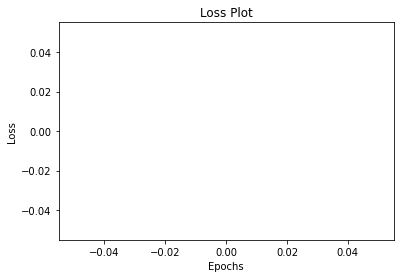

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def evaluate(word):
    hidden = decoder.reset_state(batch_size=1)

    word_tensor_val = tf.expand_dims(word, 0)
    features = encoder(word_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
    return result

def evaluate_image(image):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(download_image(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(download_image(image) * 255).astype(np.uint8)

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [0]:
for _ in range(30):
  rid = np.random.randint(0, len(word_val))
  embedding = word_val[rid]
  caption = None
  i = 0
  for sentence in filtered_caption_list:
    if np.allclose(sentence['image_embedding'], embedding) or np.allclose(sentence['text_embedding'], embedding):
      caption = sentence
      break
    i += 1

  real_caption = caption['en']

  text_result = evaluate(caption['text_embedding'])
  image_result = evaluate(caption['image_embedding'])

  print('Real Caption:', real_caption.replace(' <end>', '').replace('<start> ', ''))
  print('Real Caption:', i)
  print('Caption image:', caption['image'])
  print('Predicted Caption by text:', ' '.join(text_result).replace(' <end>', '').replace('<start> ', ''))
  print('Predicted Caption by image:', ' '.join(image_result).replace(' <end>', '').replace('<start> ', ''))
  print('')

Real Caption: a proffessional baseball player up to bat with a crowd behind him.
Real Caption: 1133
Caption image: http://farm6.staticflickr.com/5450/9860361083_5d5601c930_z.jpg
Predicted Caption by text: promaskaviskais beisbola spēlētājs ar pūli aiz muguras
Predicted Caption by image: beisbola spēlētāju grupa kas spēlē beisbola laukuma

Real Caption: a man is playing tennis and is going to return the ball
Real Caption: 1334
Caption image: http://farm5.staticflickr.com/4008/4568927357_bfbb339e27_z.jpg
Predicted Caption by text: vīrietis spēlē tenisu un gatavojas atgriezt bumbu
Predicted Caption by image: tenisa raketi

Real Caption: three females impatiently waiting. two of them are on their cell phones
Real Caption: 1638
Caption image: http://farm4.staticflickr.com/3514/3706426310_77d7aa7e2d_z.jpg
Predicted Caption by text: trīs sievietes <unk> gaida ka divas no <unk> <unk>
Predicted Caption by image: cilvēks kurš <unk> aiz diviem maziem malciņiem

Real Caption: a piece of luggage is

Real Caption: <start> sieviete, kas sēž uz dīvāna pie klēpjdatora. <end>
Predicted Caption: pie klēpjdatora <end>


ValueError: ignored

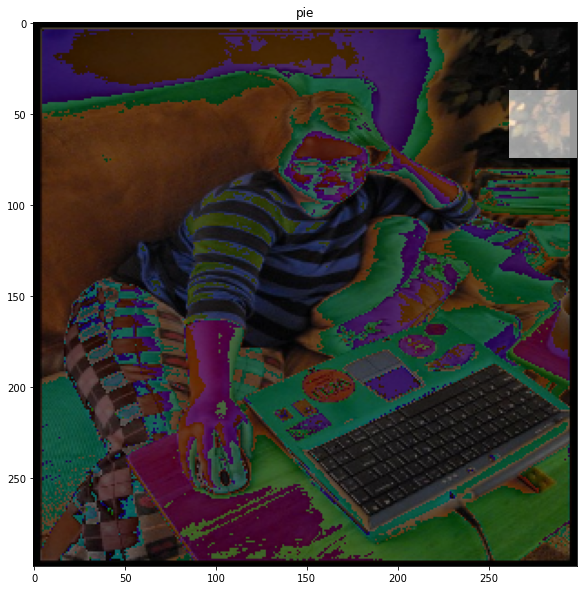

In [0]:
# image caption
rid = np.random.randint(0, len(filtered_caption_list))
caption = filtered_caption_list[rid]
real_caption = caption['lv']


result, attention_plot = evaluate_image(caption['image'])

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(result))

plot_attention(caption['image'], result, attention_plot)